In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/gdrive/MyDrive/CSE256_SP23/project/medical_abstract_data/medical_tc_train.csv', index_col=0)
df_train.reset_index(inplace=True)
df_train.columns=['label', 'text']
df_train.label = df_train.label.values-1
df_train['text_len'] = df_train['text'].apply(len).values

df_test = pd.read_csv('/content/gdrive/MyDrive/CSE256_SP23/project/medical_abstract_data/medical_tc_test.csv', index_col=0)
df_test.reset_index(inplace=True)
df_test.columns=['label', 'text']
df_test.label = df_test.label.values-1
df_test['text_len'] = df_test['text'].apply(len).values

max_length=1024
df_train['text'] = df_train.text.apply(lambda x:x[:max_length])
df_test['text'] = df_test.text.apply(lambda x:x[:max_length])

In [3]:
df_train.head()

,label,text,text_len
0,4,Tissue changes around loose prostheses. A cani...,1057
1,0,Neuropeptide Y and neuron-specific enolase lev...,1207
2,1,"Sexually transmitted diseases of the colon, re...",1771
3,0,Lipolytic factors associated with murine and h...,1006
4,2,Does carotid restenosis predict an increased r...,1489


In [4]:
df_test.head()

,label,text,text_len
0,2,Obstructive sleep apnea following topical orop...,1541
1,4,Neutrophil function and pyogenic infections in...,1656
2,4,A phase II study of combined methotrexate and ...,1811
3,0,Flow cytometric DNA analysis of parathyroid tu...,1943
4,3,Paraneoplastic vasculitic neuropathy: a treata...,686


Training set: 
 mean length:1229.104, min length:170, max length:3999


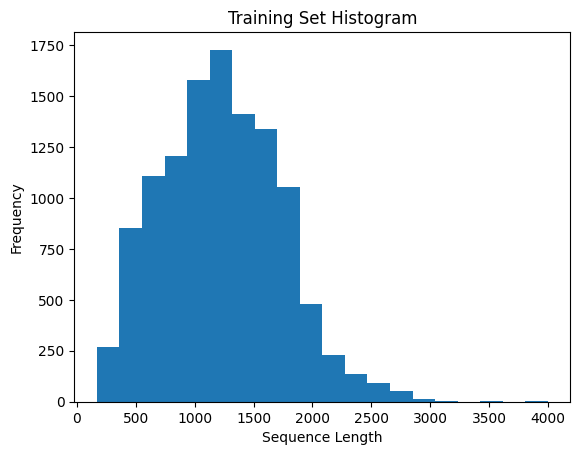

Testing set: 
 mean length:1236.908, min length:186, max length:3542


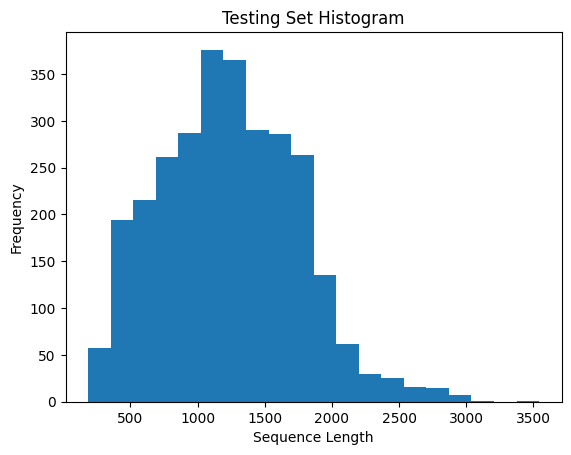

In [5]:
import matplotlib.pyplot as plt
import numpy as np

print(f'Training set: \n mean length:{df_train.text_len.mean().round(3)}, min length:{df_train.text_len.min().round(3)}, max length:{df_train.text_len.max().round(3)}')
# Create a histogram with 20 bins
plt.hist(df_train.text_len, bins=20)

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Training Set Histogram')

# Show the plot
plt.show()

print(f'Testing set: \n mean length:{df_test.text_len.mean().round(3)}, min length:{df_test.text_len.min().round(3)}, max length:{df_test.text_len.max().round(3)}')
# Create a histogram with 20 bins
plt.hist(df_test.text_len, bins=20)

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Testing Set Histogram')

# Show the plot
plt.show()

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.5 MB/s eta 0:00:00


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    return self.texts[index], self.labels[index]


# combine the input_ids and attention_masks into a TensorDataset
train_dataset = TextDataset(df_train['text'].values, df_train['label'].values)
test_dataset = TextDataset(df_test['text'].values, df_test['label'].values)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size = batch_size
)


In [ ]:
from transformers import AdamW
epochs = 10
device = 'cuda'

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
from sklearn.metrics import classification_report, accuracy_score

def get_validation_performance(dataloader, return_pred=False):
    # Put the model in evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    # Tracking variables 
    total_eval_loss = 0

    total_correct = 0


    for i, (texts, labels) in enumerate(dataloader):
      encoded_data = tokenizer.batch_encode_plus(
                              texts,
                              add_special_tokens=True,
                              return_attention_mask=True,
                              padding=True,
                              max_length=max_length,
                              return_tensors='pt',
                              truncation=True
                              )
      b_input_ids = encoded_data['input_ids'].to(device)
      b_input_mask = encoded_data['attention_mask'].to(device)
      b_labels = torch.tensor(np.array(labels)).to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,
                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        #print(pred_flat, labels_flat)
        all_preds.append(pred_flat)
        all_labels.append(labels_flat)
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / (len(dataloader)*batch_size)
    print("\nTest Accuracy:",accuracy_score(np.concatenate(all_labels).flatten(),np.concatenate(all_preds).flatten()),"\n")
    print(classification_report(np.concatenate(all_labels).flatten(),np.concatenate(all_preds).flatten()))
    return avg_val_accuracy

In [ ]:
# For each epoch...
train_loss_list = []
train_acc_list = []
test_acc_list = []
highest_test_acc = 0

for epoch_i in tqdm(range(epochs)):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    model.train()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_correct = 0

    for i, (texts, labels) in enumerate(train_dataloader):
      encoded_data = tokenizer.batch_encode_plus(
                              texts,
                              add_special_tokens=True,
                              return_attention_mask=True,
                              padding=True,
                              max_length=max_length,
                              return_tensors='pt',
                              truncation=True
                              )
      b_input_ids = encoded_data['input_ids'].to(device)
      b_input_mask = encoded_data['attention_mask'].to(device)
      b_labels = torch.tensor(np.array(labels)).to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
              token_type_ids=None, 
              attention_mask=b_input_mask, 
              labels=b_labels)
      
      loss = outputs.loss
      
      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      logits = outputs.logits
      logits = logits.detach().cpu().numpy()
      pred_flat = np.argmax(logits, axis=1).flatten()
      label_ids = b_labels.to('cpu').numpy()
      labels_flat = label_ids.flatten()
      
      num_correct = np.sum(pred_flat == labels_flat)
      total_correct += num_correct

    total_train_loss /= (len(train_dataloader)*batch_size)
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    train_acc = float(total_correct) / (len(train_dataloader)*batch_size)
    print(f"Training accuracy: {train_acc}")
    test_acc = get_validation_performance(test_dataloader)
    #print(f"Test accuracy: {test_acc}")
    train_loss_list.append(total_train_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if test_acc > highest_test_acc:
      highest_test_acc = test_acc
      torch.save(model.state_dict(), '/content/gdrive/MyDrive/CSE256_SP23/project/bert_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...
Total loss: 0.06447760745821071
Training accuracy: 0.575744459833795

Test Accuracy: 0.6308864265927978 

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       633
           1       0.53      0.75      0.62       299
           2       0.59      0.64      0.61       385
           3       0.66      0.82      0.73       610
           4       0.61      0.34      0.44       961

    accuracy                           0.63      2888
   macro avg       0.62      0.67      0.63      2888
weighted avg       0.63      0.63      0.61      2888



 10%|█         | 1/10 [11:01<1:39:15, 661.74s/it]


======== Epoch 2 / 10 ========
Training...
Total loss: 0.051125161460706565
Training accuracy: 0.6550380886426593

Test Accuracy: 0.6346952908587258 

              precision    recall  f1-score   support

           0       0.68      0.87      0.77       633
           1       0.56      0.65      0.60       299
           2       0.61      0.61      0.61       385
           3       0.69      0.74      0.71       610
           4       0.58      0.42      0.49       961

    accuracy                           0.63      2888
   macro avg       0.62      0.66      0.63      2888
weighted avg       0.63      0.63      0.62      2888



 20%|██        | 2/10 [21:49<1:27:06, 653.34s/it]


======== Epoch 3 / 10 ========
Training...
Total loss: 0.04552823868309279
Training accuracy: 0.685595567867036

Test Accuracy: 0.6367728531855956 

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       633
           1       0.56      0.61      0.58       299
           2       0.64      0.59      0.61       385
           3       0.65      0.83      0.72       610
           4       0.64      0.37      0.47       961

    accuracy                           0.64      2888
   macro avg       0.63      0.66      0.63      2888
weighted avg       0.64      0.64      0.62      2888



 30%|███       | 3/10 [32:38<1:16:00, 651.48s/it]


======== Epoch 4 / 10 ========
Training...
Total loss: 0.04095559040538533
Training accuracy: 0.7066308864265928


 40%|████      | 4/10 [43:24<1:04:56, 649.47s/it]


Test Accuracy: 0.6180747922437673 

              precision    recall  f1-score   support

           0       0.70      0.77      0.74       633
           1       0.50      0.76      0.60       299
           2       0.61      0.51      0.56       385
           3       0.65      0.80      0.71       610
           4       0.58      0.40      0.48       961

    accuracy                           0.62      2888
   macro avg       0.61      0.65      0.62      2888
weighted avg       0.62      0.62      0.61      2888


======== Epoch 5 / 10 ========
Training...
Total loss: 0.03749551587812912
Training accuracy: 0.722472299168975


 50%|█████     | 5/10 [54:11<54:01, 648.35s/it]  


Test Accuracy: 0.6011080332409973 

              precision    recall  f1-score   support

           0       0.69      0.72      0.71       633
           1       0.50      0.68      0.57       299
           2       0.53      0.63      0.58       385
           3       0.67      0.72      0.69       610
           4       0.56      0.41      0.47       961

    accuracy                           0.60      2888
   macro avg       0.59      0.63      0.60      2888
weighted avg       0.60      0.60      0.60      2888


======== Epoch 6 / 10 ========
Training...
Total loss: 0.034021689408198205
Training accuracy: 0.7385734072022161


 60%|██████    | 6/10 [1:04:58<43:11, 647.85s/it]


Test Accuracy: 0.5772160664819944 

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       633
           1       0.47      0.55      0.51       299
           2       0.55      0.50      0.53       385
           3       0.62      0.77      0.69       610
           4       0.50      0.41      0.45       961

    accuracy                           0.58      2888
   macro avg       0.57      0.59      0.57      2888
weighted avg       0.57      0.58      0.57      2888


======== Epoch 7 / 10 ========
Training...
Total loss: 0.03155895236781553
Training accuracy: 0.7469702216066482


 70%|███████   | 7/10 [1:15:45<32:22, 647.58s/it]


Test Accuracy: 0.5779085872576177 

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       633
           1       0.48      0.53      0.50       299
           2       0.51      0.64      0.57       385
           3       0.64      0.75      0.69       610
           4       0.52      0.38      0.43       961

    accuracy                           0.58      2888
   macro avg       0.56      0.60      0.58      2888
weighted avg       0.57      0.58      0.57      2888


======== Epoch 8 / 10 ========
Training...
Total loss: 0.029112202361086772
Training accuracy: 0.7542416897506925


 80%|████████  | 8/10 [1:26:32<21:34, 647.36s/it]


Test Accuracy: 0.5602493074792244 

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       633
           1       0.45      0.38      0.41       299
           2       0.52      0.57      0.54       385
           3       0.61      0.76      0.68       610
           4       0.48      0.40      0.44       961

    accuracy                           0.56      2888
   macro avg       0.55      0.56      0.55      2888
weighted avg       0.55      0.56      0.55      2888


======== Epoch 9 / 10 ========
Training...
Total loss: 0.02717384896718399
Training accuracy: 0.7649757617728532


 90%|█████████ | 9/10 [1:37:23<10:48, 648.59s/it]


Test Accuracy: 0.5557479224376731 

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       633
           1       0.45      0.51      0.48       299
           2       0.51      0.53      0.52       385
           3       0.60      0.73      0.66       610
           4       0.49      0.40      0.44       961

    accuracy                           0.56      2888
   macro avg       0.55      0.57      0.55      2888
weighted avg       0.55      0.56      0.55      2888


======== Epoch 10 / 10 ========
Training...
Total loss: 0.02570777328960969
Training accuracy: 0.7635041551246537


100%|██████████| 10/10 [1:48:10<00:00, 649.04s/it]


Test Accuracy: 0.5290858725761773 

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       633
           1       0.43      0.44      0.43       299
           2       0.55      0.46      0.50       385
           3       0.61      0.65      0.62       610
           4       0.43      0.45      0.44       961

    accuracy                           0.53      2888
   macro avg       0.53      0.52      0.53      2888
weighted avg       0.53      0.53      0.53      2888



In [ ]:
def plot_graph(list_data, title = ''):
  fig, ax = plt.subplots()

# Plot the training loss
  ax.plot(list_data)

  # Set the labels and title
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(f'{title} over Epochs')

  # Display the plot
  plt.show()

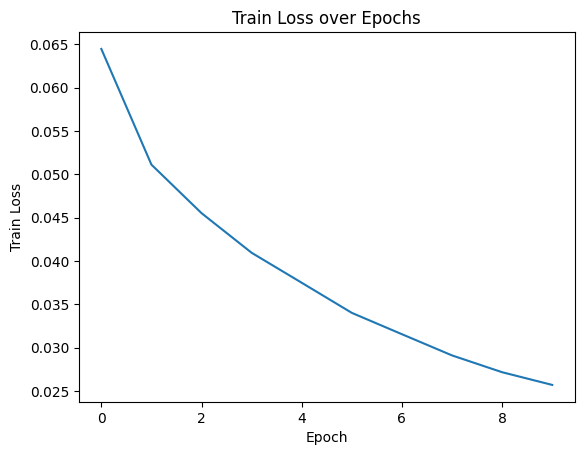

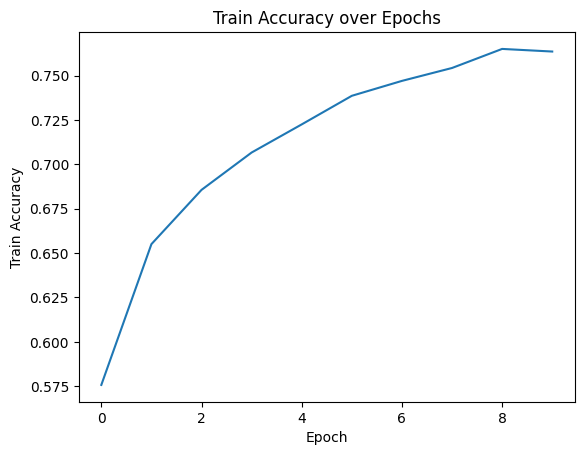

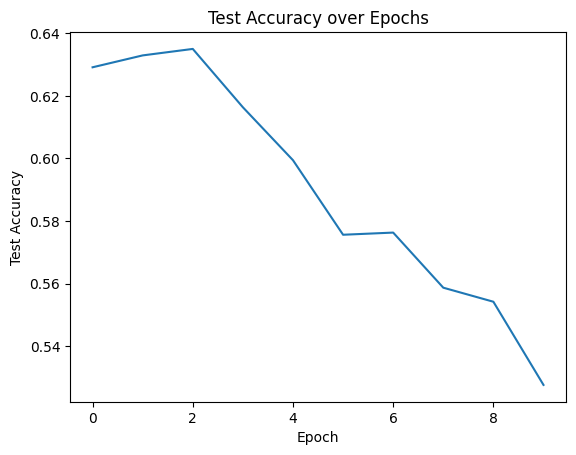

In [ ]:
plot_graph(train_loss_list, title = 'Train Loss')
plot_graph(train_acc_list, title = 'Train Accuracy')
plot_graph(test_acc_list, title = 'Test Accuracy')

In [11]:
device = 'cuda'
get_validation_performance(test_dataloader)


Test Accuracy: 0.10560941828254848 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.10      0.97      0.19       299
           2       0.13      0.02      0.03       385
           3       0.00      0.00      0.00       610
           4       0.44      0.01      0.02       961

    accuracy                           0.11      2888
   macro avg       0.14      0.20      0.05      2888
weighted avg       0.18      0.11      0.03      2888



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.10531767955801105

In [12]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/CSE256_SP23/project/bert_model.pth'))

<All keys matched successfully>

In [13]:
get_validation_performance(test_dataloader)


Test Accuracy: 0.6367728531855956 

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       633
           1       0.56      0.61      0.58       299
           2       0.64      0.59      0.61       385
           3       0.65      0.83      0.72       610
           4       0.64      0.37      0.47       961

    accuracy                           0.64      2888
   macro avg       0.63      0.66      0.63      2888
weighted avg       0.64      0.64      0.62      2888



0.6350138121546961

In [14]:
from tqdm import tqdm
def get_error_examples(dataloader, num = 10):
  # Put the model in evaluation mode
  model.eval()

  error_examples = []

  for i, (texts, labels) in tqdm(enumerate(dataloader)):
    encoded_data = tokenizer.batch_encode_plus(
                          texts,
                          add_special_tokens=True,
                          return_attention_mask=True,
                          padding=True,
                          max_length=max_length,
                          return_tensors='pt',
                          truncation=True
                          )
    b_input_ids = encoded_data['input_ids'].to(device)
    b_input_mask = encoded_data['attention_mask'].to(device)
    b_labels = torch.tensor(np.array(labels)).to(device)
      
    with torch.no_grad():        
      outputs = model(b_input_ids, 
              token_type_ids=None, 
              attention_mask=b_input_mask,
              labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits
      
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the number of correctly labeled examples in batch
      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()
      
      for j, equal in enumerate(pred_flat == labels_flat):
        if not equal:
          error_examples.append((batch_size*i+j, texts[j], int(labels[j].numpy()), pred_flat[j]))

  return error_examples

In [15]:
error_examples = get_error_examples(test_dataloader)

181it [00:57,  3.15it/s]


In [16]:
import pandas as pd
error_df = pd.DataFrame(columns=['index', 'text', 'label', 'pred'])

for row in error_examples:
    error_df.loc[len(error_df)] = row

error_df.head()

,index,text,label,pred
0,0,Obstructive sleep apnea following topical orop...,2,4
1,1,Neutrophil function and pyogenic infections in...,4,0
2,2,A phase II study of combined methotrexate and ...,4,0
3,4,Paraneoplastic vasculitic neuropathy: a treata...,3,0
4,8,Reversibility of hepatic fibrosis in experimen...,4,1


In [17]:
len(error_examples)

1049

In [18]:
error_count = np.zeros((5,5))
for i in range(len(error_df)):
  error_count[error_df.loc[i]['label'],error_df.loc[i]['pred']] += 1

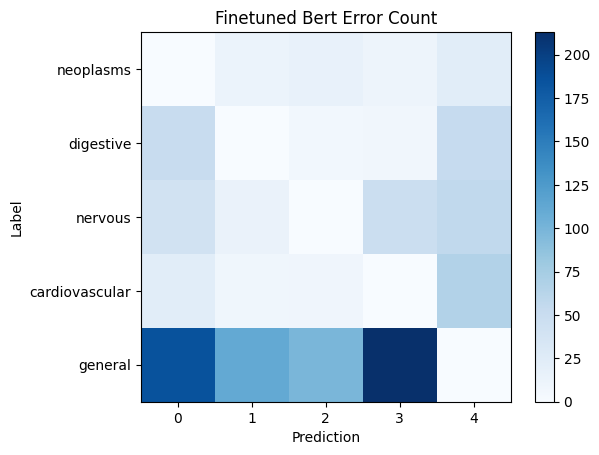

In [19]:
fig, ax = plt.subplots()

# Plot the heatmap using imshow
heatmap = ax.imshow(error_count, cmap='Blues', norm=plt.Normalize(vmin=0, vmax=np.max(error_count)))

# Add colorbar
cbar = plt.colorbar(heatmap)

# Set the title and labels
ax.set_title('Finetuned Bert Error Count')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')

# Customize the tick labels for x and y axes
x_ticks = np.arange(5)
y_ticks = np.arange(5)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_yticklabels(['neoplasms', 'digestive', 'nervous', 'cardiovascular', 'general'])

# Display the plot
plt.show()

In [ ]:
for i in range(len(error_df)):
  error_count[error_df.loc[i]['label'],error_df.loc[i]['pred']] += 1

In [88]:
from collections import defaultdict
error_cases = defaultdict(list)
for i in range(len(error_df)):
  error_cases[(error_df.loc[i]['label'],error_df.loc[i]['pred'])].append(error_df.loc[i]['text'])

In [90]:
error_cases[(0,3)]

['Conservative therapy for adnexal torsion. A case report. Adnexal torsion has traditionally been treated with oophorectomy because of the fear that untwisting the ovarian pedicle may result in a thrombotic embolus. Such a patient had bilateral adnexal torsion secondary to dermoid cysts. Since standard therapy, oophorectomy, was performed, the patient was surgically castrated. A review of the literature revealed no reported cases of a thrombotic embolus arising from the untwisting of twisted adnexa and supported conservation of the adnexa rather than routine extirpation, except when necrotic. ',
 'Epirubicin cardiotoxicity: a study of 135 patients with advanced breast cancer. The cardiotoxicity of epirubicin (EPI) was evaluated clinically, radiologically, with ECG, and with multiple ECG-gated radionuclide determination of the left ventricular ejection fraction (LVEF) during rest in 135 patients with advanced breast cancer. The EPI doses were 60 mg/m2 on days 1 and 8 every 4 weeks or 45